# 02 Model Evaluation
Multiple pretrained model will be evaluated. A smaller dataset of 30000 bin images (for Expected Qty 0 to 5, total 6 classes) will be used in the evaluation.

The evaluation outcome is to determine the models with the best/better performance in terms of accuracy. Accuracy indicates how often the model can correctly predicts the total number of objects in a bin (i.e. in one image). This is especially applicable during model evaluation, where a smaller dataset is used, and the data between the classes are balanced.

---
### 1. Import Libraries and variable setting


In [1]:
from __future__ import print_function

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import keras
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.callbacks import EarlyStopping
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet152V2, DenseNet201, InceptionResNetV2, EfficientNetV2L, VGG19
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import json
import datetime
import gc

For use when running the notebook on Google Colab. Comment these when running on local laptop

In [2]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/ColabData'
image_path = '/content/bin-images-224x224/bin-images-224x224'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For use when running the notebook on local laptop. Comment this line when running on Google Colab.

In [3]:
# drive_path = '../data'
# image_path = '../data/bin-images-224x224'

In [3]:
sample_size = 5000  # sample size for each Qty count
test_remarks = "6x5000_522b" #remark to be prefixed on logs and eval_result
image_augment = False  #whether to apply Image Augmentation by ImageDataGenerator during model fit


---
### 2. Load sample images/labels

In [4]:
# ! kaggle datasets download williamhyun/amazon-bin-image-dataset-536434-images-224x224

Dataset URL: https://www.kaggle.com/datasets/williamhyun/amazon-bin-image-dataset-536434-images-224x224
License(s): CC-BY-NC-SA-4.0
100% 3.50G/3.50G [02:45<00:00, 23.4MB/s]
100% 3.50G/3.50G [02:45<00:00, 22.6MB/s]


In [5]:
# !unzip /content/amazon-bin-image-dataset-536434-images-224x224.zip -d /content

Streaming output truncated to the last 5000 lines.
  inflating: /content/bin-images-224x224/bin-images-224x224/95055.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95056.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95057.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95058.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95059.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95060.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95061.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95062.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95063.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95064.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95065.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95066.jpg  
  inflating: /content/bin-images-224x224/bin-images-224x224/95067.jpg  
  inflating: 

load the prepared sampled images/labels from pickle

In [6]:
with open(f"{drive_path}/metadata_class_Q0_Q1_Q2_Q3_Q4_Q5_519a.pkl", 'rb') as file_images:
    metadata_class_df = pickle.load(file_images)
    file_images.close()

In [7]:
metadata_class_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 361967 entries, 1 to 536433
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   bin_fcsku_data      361967 non-null  object
 1   expected_quantity   361967 non-null  int64 
 2   image_fname         361967 non-null  object
 3   sku_count           361967 non-null  int64 
 4   blurred_image_t100  361967 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 14.2+ MB


In [8]:
metadata_class_df['expected_quantity'].count()

361967

In [9]:
metadata_class_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

expected_quantity  blurred_image_t100
0                  False                  5360
                   True                   4541
1                  False                 34523
                   True                   6824
2                  False                 67132
                   True                   9931
3                  False                 79327
                   True                  10931
4                  False                 71156
                   True                   9594
5                  False                 55092
                   True                   7556
Name: count, dtype: int64

In [10]:
def sampling_rows(group):
    # return group.sample(n=min(len(group), sample_per_class), random_state=42)
    return group.sample(n=min(len(group), sample_size))

# using the groupby, together with sampling_rows function, to sample out "sample per class" images
sampled_metadata_df = metadata_class_df[metadata_class_df['blurred_image_t100']==False].groupby('expected_quantity', group_keys=False).apply(sampling_rows)

# to randomize the row index.
sampled_metadata_df = sampled_metadata_df.sample(frac=1, random_state=42).reset_index(drop=True)
sampled_metadata_df.head(5)

,bin_fcsku_data,expected_quantity,image_fname,sku_count,blurred_image_t100
0,{},0,188601.jpg,0,False
1,"{'B00DH0QM7K': {'asin': 'B00DH0QM7K', 'height'...",4,146929.jpg,4,False
2,"{'B000CO7IK4': {'asin': 'B000CO7IK4', 'height'...",4,313770.jpg,4,False
3,"{'B00006JNTZ': {'asin': 'B00006JNTZ', 'height'...",5,481501.jpg,2,False
4,{},0,164666.jpg,0,False


In [5]:
sampled_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   bin_fcsku_data      30000 non-null  object
 1   expected_quantity   30000 non-null  int64 
 2   image_fname         30000 non-null  object
 3   sku_count           30000 non-null  int64 
 4   blurred_image_t100  30000 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 966.9+ KB


In [6]:
sampled_metadata_df.groupby('expected_quantity')[['blurred_image_t100']].value_counts()

expected_quantity  blurred_image_t100
0                  False                 5000
1                  False                 5000
2                  False                 5000
3                  False                 5000
4                  False                 5000
5                  False                 5000
Name: count, dtype: int64

To preload the images specified in sampled_metadata_df into memory, and converted to numpy ndarray (224, 224, 3)


In [7]:
# labels classes are based on the "expected_quantity"  0, 1, 2, ....
class_num = set(sampled_metadata_df['expected_quantity'])
nClasses = len(class_num)

# class_label_map will map the "qty count" to "label", countinous running number starting from 0
def class_labels(num):
        return { n:i for i,n in enumerate(num)}

class_label_map = class_labels(class_num)
class_label_map

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5}

In [8]:
images = []
labels = []
filename = []

def prep_image_for_ML_cv2(row):
    image = cv2.imread(image_path+'/'+row.image_fname)
    images.append(image)
    labels.append(np.array(class_label_map[row.expected_quantity]))
    filename.append(row.image_fname)

sampled_metadata_df.apply(prep_image_for_ML_cv2, axis='columns')

y_labels = np.empty( (len(labels),1), dtype=np.int8 )
for i, label_sample in enumerate(labels):
    y_labels[i] = label_sample

x_images = np.array( images, dtype=np.float32 ) / 255.0
# x_images = np.array( images, dtype=np.float32 )


Images were read into `x_images`, while corresponding labels in the `y_labels`

In [9]:
len(x_images)

30000

In [10]:
x_images.shape

(30000, 224, 224, 3)

In [11]:
x_images[0]

array([[[0.49803922, 0.70980394, 0.84705883],
        [0.5019608 , 0.7137255 , 0.8509804 ],
        [0.49803922, 0.7176471 , 0.85490197],
        ...,
        [0.5294118 , 0.8117647 , 1.        ],
        [0.52156866, 0.8117647 , 1.        ],
        [0.52156866, 0.8117647 , 1.        ]],

       [[0.49803922, 0.70980394, 0.84705883],
        [0.5019608 , 0.7137255 , 0.8509804 ],
        [0.49803922, 0.7176471 , 0.85490197],
        ...,
        [0.50980395, 0.7921569 , 0.98039216],
        [0.50980395, 0.7921569 , 0.98039216],
        [0.5058824 , 0.79607844, 0.9843137 ]],

       [[0.49411765, 0.7058824 , 0.84313726],
        [0.49803922, 0.70980394, 0.84705883],
        [0.49803922, 0.7176471 , 0.85490197],
        ...,
        [0.5176471 , 0.8       , 0.9843137 ],
        [0.5176471 , 0.8       , 0.9843137 ],
        [0.5176471 , 0.8       , 0.9843137 ]],

       ...,

       [[0.4745098 , 0.6862745 , 0.80784315],
        [0.47843137, 0.6901961 , 0.8117647 ],
        [0.47843137, 0

In [12]:
len(y_labels)

30000

In [13]:
y_labels.shape

(30000, 1)

In [14]:
y_labels[0:10]

array([[0],
       [4],
       [4],
       [5],
       [0],
       [1],
       [1],
       [1],
       [2],
       [3]], dtype=int8)

Export the sampled_metadata_df as the record for model_evaluation sampled data.

In [16]:
sampledata_class_pickle_file = open(f'{drive_path}/sampleddata_class_Q0_Q1_Q2_Q3_Q4_Q5_519a.pkl','wb')
pickle.dump(sampled_metadata_df, sampledata_class_pickle_file)
sampledata_class_pickle_file.close()

visual checking (the first 10 images in the sampled dataset) to make sure the sampled images are good

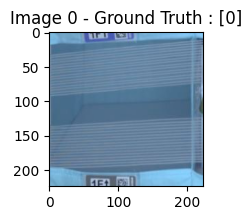

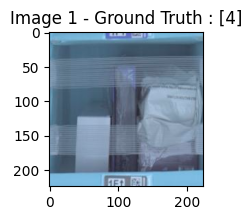

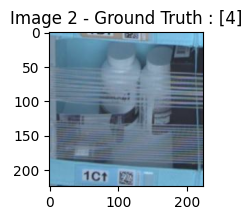

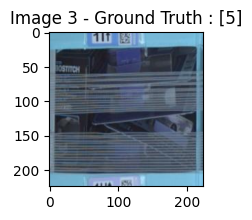

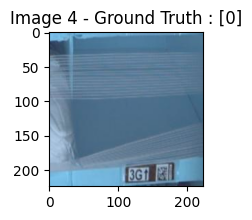

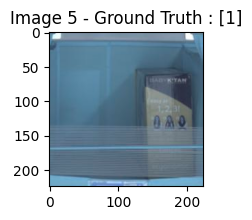

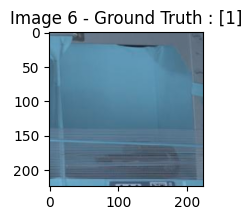

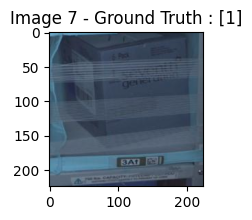

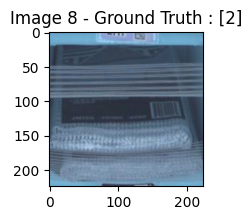

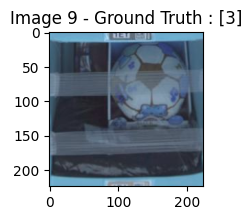

In [15]:
for i in range(10):
    plt.figure(figsize=[6,2])

    # plt.subplot(121)
    plt.imshow(x_images[i,:,:], cmap='gray')
    plt.title(f"Image {i} - Ground Truth : {format(y_labels[i])}")


---
# 3. Get Ready the sample images and labels

Train-Test-Split the data into training set and testing set, with Stratify set based on the labels in order to ensure balanced data.

In [16]:
train_images, test_images, train_labels, test_labels = train_test_split(x_images,
                                                                        y_labels,
                                                                        test_size = 0.2,
                                                                        stratify=y_labels,
                                                                        random_state=42)

In [17]:
train_images.shape

(24000, 224, 224, 3)

In [18]:
train_labels.shape

(24000, 1)

In [19]:
test_images.shape

(6000, 224, 224, 3)

In [20]:
test_labels.shape

(6000, 1)

one-hot-encoding to the train_labels and test_labels

In [21]:
train_labels_oh = to_categorical(train_labels)
test_labels_oh = to_categorical(test_labels)

In [22]:
train_labels_oh

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [23]:
test_labels_oh

array([[0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

Print training sample shape, test sample shape and total number of classes present from the sampled data set. There are 6 classes expected. Print two example image from training set and test set for visible verification.


Training data shape :  (24000, 224, 224, 3) (24000, 1)
Testing data shape :  (6000, 224, 224, 3) (6000, 1)
Total number of outputs :  6
Output classes :  [0 1 2 3 4 5]


Text(0.5, 1.0, 'Ground Truth : [0]')

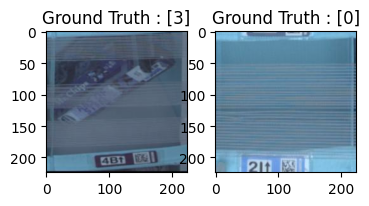

In [24]:
print('Training data shape : ', train_images.shape, train_labels.shape)

print('Testing data shape : ', test_images.shape, test_labels.shape)

# Find the unique numbers from the train labels
classes = np.unique(train_labels)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

plt.figure(figsize=[4,2])

# Display the second image in training data
plt.subplot(121)
plt.imshow(train_images[15,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_labels[15]))

# # Display the second image in testing data
plt.subplot(122)
plt.imshow(test_images[25,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_labels[25]))

In [25]:
# x_images and y_labels are no longer required. Del them to clear memory space.
del x_images
del y_labels
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

28990

---
# 4. Model Configuration

Initialize `evaluate_result`, a dictionary to hold all the model evaluation result


In [26]:
evaluate_result = {}

Functions to create the models with different pretrained models to be evaluated. Each Pretrained model gets its own function, in the event model-specific tuning is required.

In [27]:
def create_ResnetModel():
    pre_trained_model = ResNet152V2(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)
    model.summary(show_trainable=True)

    return model

In [28]:
def create_DenseNet_Model():
    pre_trained_model = DenseNet201(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model

In [29]:
def create_MobilenetV2_Model():
    pre_trained_model = MobileNetV2(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model

In [30]:
def create_VGG_Model():
    pre_trained_model = VGG19(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model

In [31]:
def create_EfficientNet_Model():
    pre_trained_model = EfficientNetV2L(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model

In [32]:
def create_InceptionResNet_Model():
    pre_trained_model = InceptionResNetV2(include_top = False,
                                    weights="imagenet",
                                    input_shape=train_images.shape[1:])
    pre_trained_model.trainable = False

    x = pre_trained_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.55)(x)
    predictions = Dense(nClasses, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    return model

In [33]:
def create_CNN_Model():
    model = Sequential()
    # The first two layers with 32 filters of window size 3x3
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=train_images.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nClasses, activation='softmax'))

    return model

`train_model` function encapsulated the model compilation and model fit. The function also enable model architecture to be saved in log, also enable tensorflow to capture the runtime history, for future reference purpose.

In [34]:
def train_model(model1, train_remarks, train_x, train_y_oh, test_x, test_y_oh, with_ImageAugmentation):
  # preparing the model fit - AdamW optimizer will be used for all model evaluation
  opt = keras.optimizers.AdamW(learning_rate=0.0001)
  model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  # preparing the model fit - initialize the TensorBoard
  timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  log_dir = f"./logs/{timestamp}_{train_remarks}"
  tensorboard_callback = TensorBoard(log_dir=log_dir)

  # preparing the model fit - EarlyStopping regularization setup to prevent unnecessary overrun
  early_stop = EarlyStopping( monitor = 'val_loss',
                            min_delta = 0,
                            patience = 5,
                            mode = 'auto')

  if with_ImageAugmentation == False:
    history = model1.fit(train_x,
                        train_y_oh,
                        batch_size=128,
                        epochs=20,
                        verbose=1,
                        validation_data=(test_x, test_y_oh),
                        callbacks=[tensorboard_callback, early_stop])
  else:
      #initiate minimal image augmentation, to avoid generating too many augmentation images and affect runtime duration
      datagen = ImageDataGenerator( rotation_range=20, horizontal_flip=True, fill_mode='nearest')

      history = model1.fit(datagen.flow(train_x,
                                  train_y_oh,
                                  batch_size=128,
                                  seed = 42,
                                  shuffle=True,
                                  ),
                    epochs=15,
                    verbose=1,
                    validation_data=(test_x, test_y_oh),
                    callbacks=[tensorboard_callback, early_stop])

  # Export model architecture/configuration and hyperparameters to json file, stored in the same log folder as Tensorboard
  experiment_config = { 'model_architecture' : model1.to_json(), }
  with open(log_dir+'/config.json', 'w') as fp:
      json.dump(experiment_config, fp, indent=4)

  return history



`eval_model` is one function that carries out the model evaluation, including
- loss curve and accuracy curve
- confusion matrix
- metrics evaluation


In [35]:
def eval_model(model1, train_remarks, test_x, test_y, test_y_oh, fit_history, eval_result, num_classes):

  def plot_metric_curve(t_metric, v_metric, metric_n, title):
    plt.figure(figsize=(8, 6))

    # Generate line plot
    plt.plot(t_metric, label='Train'+metric_n)
    plt.plot(v_metric, label='Validation'+metric_n)

    plt.xlabel('Epoch')
    plt.ylabel(metric_n)
    plt.title(title+" "+metric_n+" Curve")
    plt.legend();

  # plot loss curve
  train_loss = fit_history.history['loss']
  value_loss = fit_history.history['val_loss']
  plot_metric_curve(train_loss, value_loss, "Loss", train_remarks)

  # plot accuracy curve
  train_accuracy = fit_history.history['accuracy']
  value_accuracy = fit_history.history['val_accuracy']
  plot_metric_curve(train_accuracy, value_accuracy, "Accuracy",train_remarks)

  # confusion Matrix
  y_pred = model1.predict(test_x)
  y_pred_classes = np.argmax(y_pred, axis=-1)  # Convert probabilities to class labels
  # y_true = np.argmax(test_y, axis=-1)
  cm = confusion_matrix(test_y, y_pred_classes)

  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()

  # metric evaluation
  eval_result[train_remarks] = {}
  eval_score = model1.evaluate(test_x, test_y_oh)
  eval_labels = model1.metrics_names

  eval_result[train_remarks][eval_labels[0]] = round(eval_score[0], 4)
  eval_result[train_remarks][eval_labels[1]] = round(eval_score[1], 4)

  def calculate_metrics(cm, class_index):
    TP = cm[class_index, class_index]  # Diagonal element for the specific class
    FP = np.sum(cm[:, class_index]) - TP
    FN = np.sum(cm[class_index, :]) - TP
    TN = cm.sum() - TP - FP - FN # Calculate True Negatives
    print(f"Class={class_index}|TP={TP}, FP={FP}, FN={FN}, TN={TN}")

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score, specificity, accuracy

  for class_ind in range(num_classes):
    precision, recall, f1_score, specificity, accuracy = calculate_metrics(cm, class_index=class_ind)
    eval_result[train_remarks][str(class_ind)+'_Precision'] = precision
    eval_result[train_remarks][str(class_ind)+'_Recall'] = recall
    eval_result[train_remarks][str(class_ind)+'_F1_Score'] = f1_score
    eval_result[train_remarks][str(class_ind)+'_Specificity'] = specificity
    eval_result[train_remarks][str(class_ind)+'_Accuracy'] = accuracy

  print(f"Metric evaluation for {train_remarks}>> \n{eval_result}")



In [36]:
def save_eval_result(eval_result, result_remarks):
  eval_result_df = pd.DataFrame(eval_result).T
  eval_result_df.reset_index(inplace=True)
  eval_result_df.rename(columns={'index':'Model_Eval'}, inplace=True)
  eval_result_df.to_csv(f'{drive_path}/02_ModelEval_EvalResult_{result_remarks}.csv', mode = 'a', index=False, header=True)

  eval_result_df

In [37]:
def export_trained_model(model1, train_remarks):
  keras_filename = f'{train_remarks}.h5'
  model1.save(f'{drive_path}/{keras_filename}')
  print(f"Exported trained model to file {keras_filename}")

---
# 5. Model Evaluation

For each model to be evaluated,
1. set the image_augment flag. True if image augmentation by ImageDataGenerator is required.
2. create the model.
3. call the train_model() function, with the model object as input
4. result from train_model() function, together with model object, are used as input to eval_model() function for evaluation

Argument-2 of both train_model() and eval_model() is the training_remarks. This will be a summary ID for this model fit and evaluation, for reference in the exported evaluation report (CSV) at the end.  Ensure the training_remarks is unique for each execution so that result on evaluation report will not be overwritten.

### 5.1 ResNet152V2

234545216/234545216 [==============================] - 11s 0us/step
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  Trainable  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            N          
                                                                                                             
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             N          
                                                                                                             
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           N          
                                                                                                             
 pool1_pad (ZeroPadding2D)   (None, 1

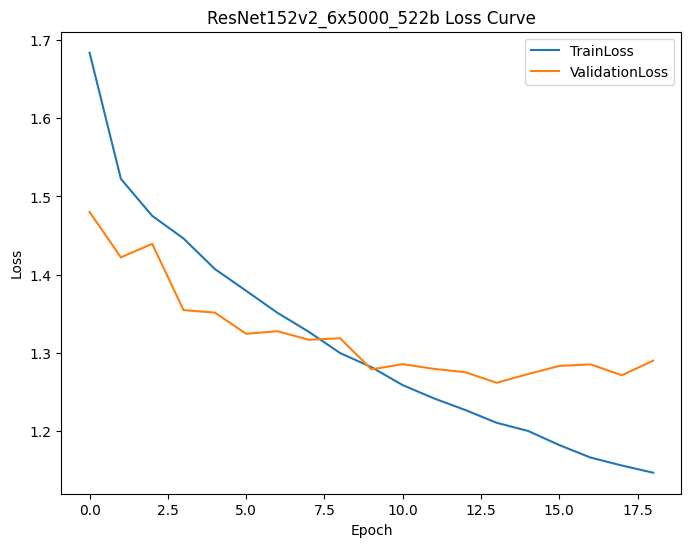

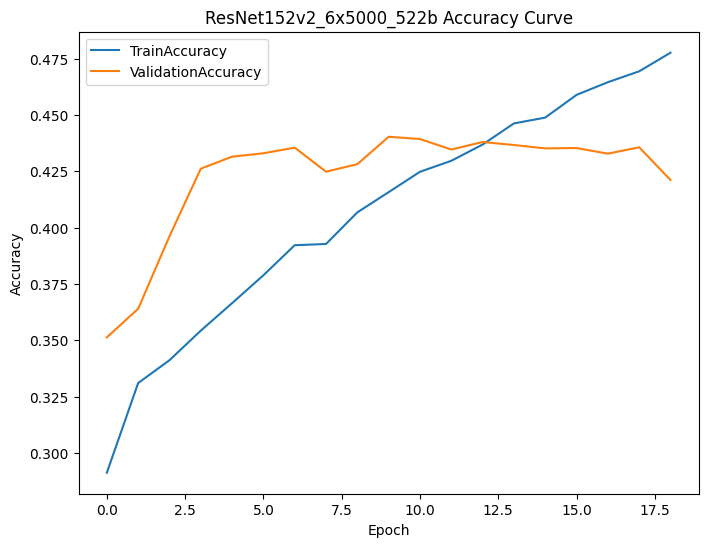

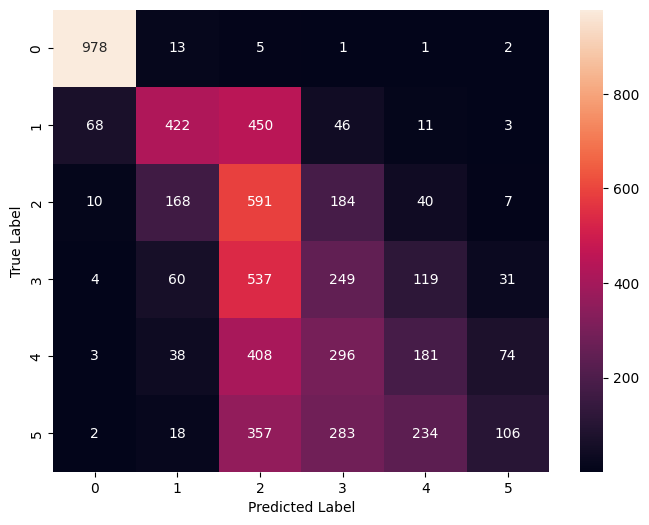

188/188 [==============================] - 10s 53ms/step - loss: 1.2899 - accuracy: 0.4212
Class=0|TP=978, FP=87, FN=22, TN=4913
Class=1|TP=422, FP=297, FN=578, TN=4703
Class=2|TP=591, FP=1757, FN=409, TN=3243
Class=3|TP=249, FP=810, FN=751, TN=4190
Class=4|TP=181, FP=405, FN=819, TN=4595
Class=5|TP=106, FP=117, FN=894, TN=4883
Metric evaluation for ResNet152v2_6x5000_522b>> 
{'ResNet152v2_6x5000_522b': {'loss': 1.2899, 'accuracy': 0.4212, '0_Precision': 0.9183098591549296, '0_Recall': 0.978, '0_F1_Score': 0.9472154963680388, '0_Specificity': 0.9826, '0_Accuracy': 0.9818333333333333, '1_Precision': 0.5869262865090403, '1_Recall': 0.422, '1_F1_Score': 0.4909831297265852, '1_Specificity': 0.9406, '1_Accuracy': 0.8541666666666666, '2_Precision': 0.25170357751277683, '2_Recall': 0.591, '2_F1_Score': 0.35304659498207885, '2_Specificity': 0.6486, '2_Accuracy': 0.639, '3_Precision': 0.23512747875354106, '3_Recall': 0.249, '3_F1_Score': 0.24186498300145703, '3_Specificity': 0.838, '3_Accuracy'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file ResNet152v2_6x5000_522b.h5


16176

In [45]:
model_ResNet = create_ResnetModel()
resnet_train_history = train_model(model_ResNet, f"ResNet152v2_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_ResNet, f"ResNet152v2_{test_remarks}", test_images, test_labels, test_labels_oh, resnet_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_ResNet, f"ResNet152v2_{test_remarks}")
del model_ResNet
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

Resnet152V2 - overall accuracy 0.4212. Overfitting is observed, which is expected at this stage due to small dataset. With model tuning and large/full dataset, overfitting can be overcome or reduce. Breaking down into classes, other than Qty 0, Qty1 and Qty2 are also having relatively moderate recall at 0.422 and 0.591 respectively. However, the confusion matrix shows that large number of predicted value at Qty 2, signaling the model overwhelmingly bias towards Qty 2 in the prediction. As the quantity move to higher value, we see a drop in accuracy and recall due to the challenging object detection as the bin get more objects.

# 5.2 DenseNet201

Epoch 1/20
188/188 [==============================] - 54s 212ms/step - loss: 1.6174 - accuracy: 0.3070 - val_loss: 1.4683 - val_accuracy: 0.3787
Epoch 2/20
188/188 [==============================] - 30s 158ms/step - loss: 1.4891 - accuracy: 0.3462 - val_loss: 1.4064 - val_accuracy: 0.4333
Epoch 3/20
188/188 [==============================] - 30s 159ms/step - loss: 1.4487 - accuracy: 0.3613 - val_loss: 1.3449 - val_accuracy: 0.4228
Epoch 4/20
188/188 [==============================] - 30s 159ms/step - loss: 1.4119 - accuracy: 0.3688 - val_loss: 1.3056 - val_accuracy: 0.4388
Epoch 5/20
188/188 [==============================] - 30s 159ms/step - loss: 1.3750 - accuracy: 0.3805 - val_loss: 1.3339 - val_accuracy: 0.4518
Epoch 6/20
188/188 [==============================] - 30s 159ms/step - loss: 1.3593 - accuracy: 0.3829 - val_loss: 1.2965 - val_accuracy: 0.4602
Epoch 7/20
188/188 [==============================] - 30s 159ms/step - loss: 1.3409 - accuracy: 0.3859 - val_loss: 1.2819 - val_ac

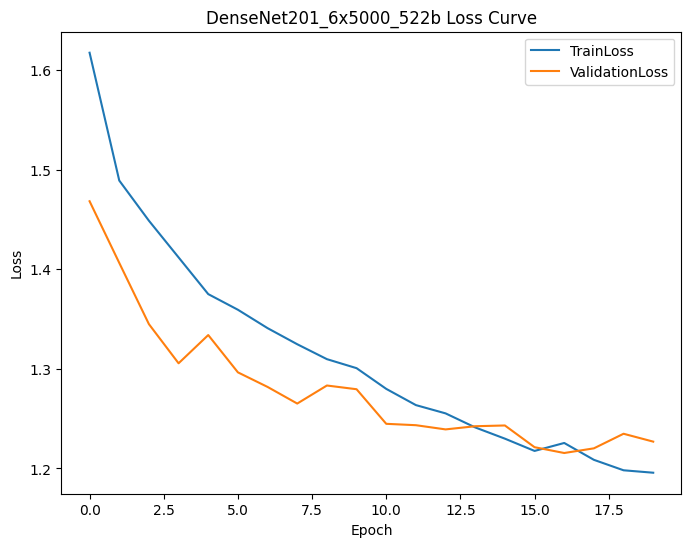

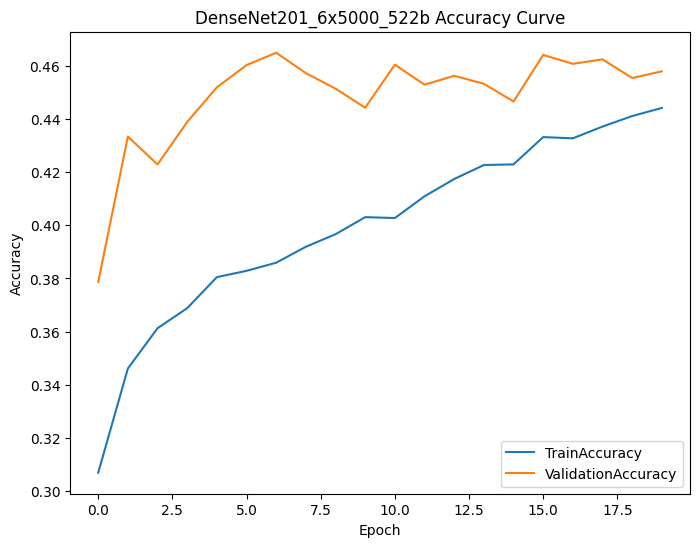

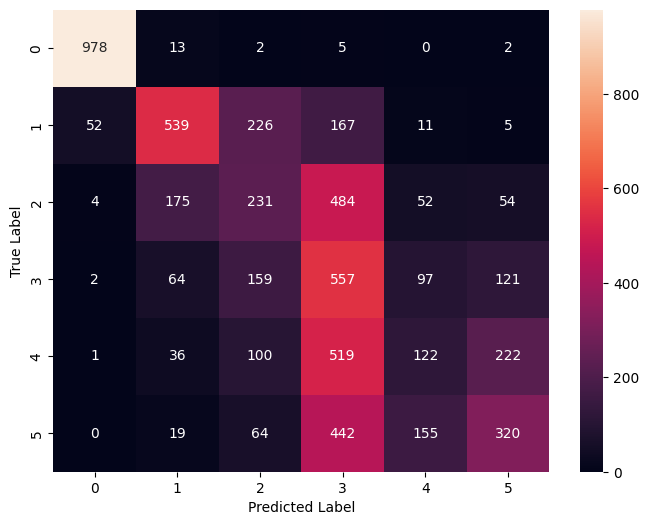

188/188 [==============================] - 8s 43ms/step - loss: 1.2269 - accuracy: 0.4578
Class=0|TP=978, FP=59, FN=22, TN=4941
Class=1|TP=539, FP=307, FN=461, TN=4693
Class=2|TP=231, FP=551, FN=769, TN=4449
Class=3|TP=557, FP=1617, FN=443, TN=3383
Class=4|TP=122, FP=315, FN=878, TN=4685
Class=5|TP=320, FP=404, FN=680, TN=4596
Metric evaluation for DenseNet201_6x5000_522b>> 
{'DenseNet201_6x5000_522b': {'loss': 1.2269, 'accuracy': 0.4578, '0_Precision': 0.9431051108968177, '0_Recall': 0.978, '0_F1_Score': 0.9602356406480117, '0_Specificity': 0.9882, '0_Accuracy': 0.9865, '1_Precision': 0.6371158392434988, '1_Recall': 0.539, '1_F1_Score': 0.5839653304442036, '1_Specificity': 0.9386, '1_Accuracy': 0.872, '2_Precision': 0.29539641943734013, '2_Recall': 0.231, '2_F1_Score': 0.25925925925925924, '2_Specificity': 0.8898, '2_Accuracy': 0.78, '3_Precision': 0.2562097516099356, '3_Recall': 0.557, '3_F1_Score': 0.35097668557025835, '3_Specificity': 0.6766, '3_Accuracy': 0.6566666666666666, '4_Pr

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file DenseNet201_6x5000_522b.h5


17558

In [39]:
model_DenseNet = create_DenseNet_Model()
densenet_train_history = train_model(model_DenseNet, f"DenseNet201_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_DenseNet,  f"DenseNet201_{test_remarks}", test_images, test_labels, test_labels_oh, densenet_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_DenseNet, f"DenseNet201_{test_remarks}")
del model_DenseNet
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> Densenet201 - overall accuracy 0.4379.  The curve line is not smooth, indicating a smaller learning rate may be required. Breaking down into classes, other than Qty 0, Qty1 and Qty3 are also having relatively moderate recall at 0.539 and 0.557 respectively. However, the confusion matrix shows that large number of predicted value at Qty 3, signaling the model overwhelmingly bias towards Qty 3 in the prediction. That seems to have indirectly affected the recall for Qty 2, which is relatively low at 0.231, contrary to the belief that lesser Qty should have better recall performance than higher Qty (e.g. Qty 3). As the quantity move to higher value, again we are seeing Qty 5 is having a higher recall than Qty 4, again signaling the model has a bias prediction. 


### 5.3 EfficientNetV2L

Epoch 1/20
188/188 [==============================] - 116s 437ms/step - loss: 1.8565 - accuracy: 0.1640 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 2/20
188/188 [==============================] - 67s 356ms/step - loss: 1.7925 - accuracy: 0.1652 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 3/20
188/188 [==============================] - 67s 357ms/step - loss: 1.7940 - accuracy: 0.1670 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 4/20
188/188 [==============================] - 67s 357ms/step - loss: 1.7924 - accuracy: 0.1673 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 5/20
188/188 [==============================] - 67s 356ms/step - loss: 1.7922 - accuracy: 0.1683 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 6/20
188/188 [==============================] - 67s 356ms/step - loss: 1.7921 - accuracy: 0.1648 - val_loss: 1.7918 - val_accuracy: 0.1667
Epoch 7/20
188/188 [==============================] - 22s 83ms/step


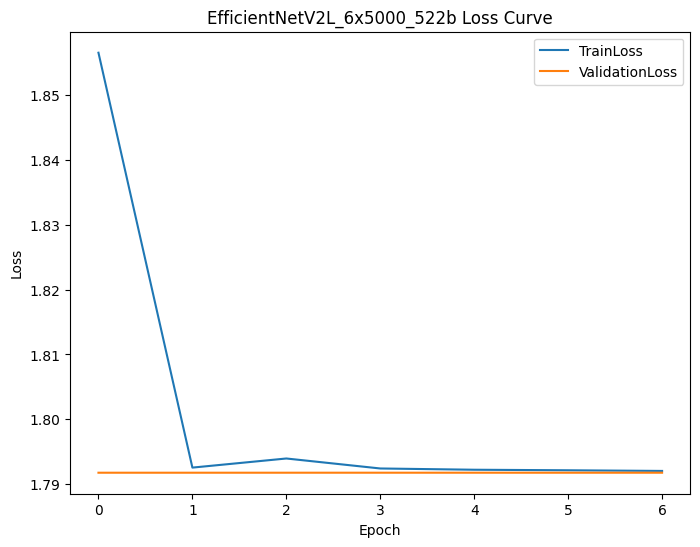

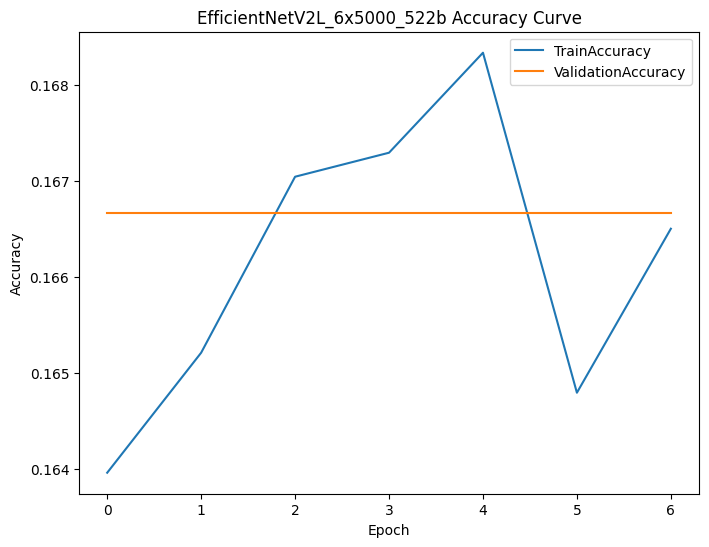

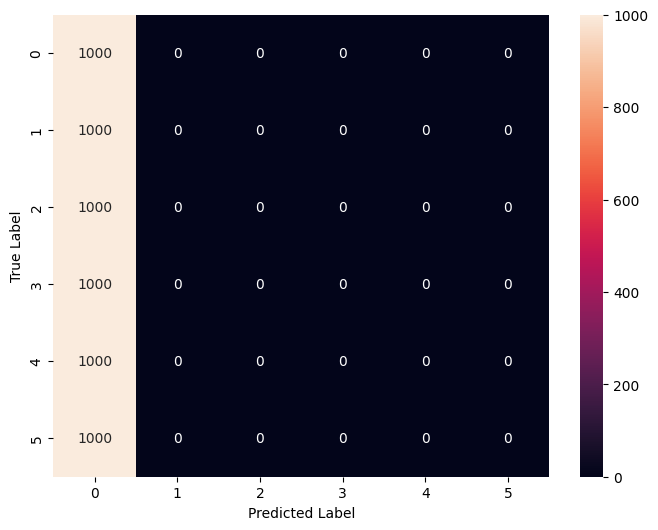

188/188 [==============================] - 16s 87ms/step - loss: 1.7918 - accuracy: 0.1667
Class=0|TP=1000, FP=5000, FN=0, TN=0
Class=1|TP=0, FP=0, FN=1000, TN=5000
Class=2|TP=0, FP=0, FN=1000, TN=5000
Class=3|TP=0, FP=0, FN=1000, TN=5000
Class=4|TP=0, FP=0, FN=1000, TN=5000
Class=5|TP=0, FP=0, FN=1000, TN=5000
Metric evaluation for EfficientNetV2L_6x5000_522b>> 
{'EfficientNetV2L_6x5000_522b': {'loss': 1.7918, 'accuracy': 0.1667, '0_Precision': 0.16666666666666666, '0_Recall': 1.0, '0_F1_Score': 0.2857142857142857, '0_Specificity': 0.0, '0_Accuracy': 0.16666666666666666, '1_Precision': nan, '1_Recall': 0.0, '1_F1_Score': nan, '1_Specificity': 1.0, '1_Accuracy': 0.8333333333333334, '2_Precision': nan, '2_Recall': 0.0, '2_F1_Score': nan, '2_Specificity': 1.0, '2_Accuracy': 0.8333333333333334, '3_Precision': nan, '3_Recall': 0.0, '3_F1_Score': nan, '3_Specificity': 1.0, '3_Accuracy': 0.8333333333333334, '4_Precision': nan, '4_Recall': 0.0, '4_F1_Score': nan, '4_Specificity': 1.0, '4_Accu

<ipython-input-35-af42cf649528>:53: RuntimeWarning: invalid value encountered in scalar divide
  precision = TP / (TP + FP)
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file EfficientNetV2L_6x5000_522b.h5


17160

In [38]:
model_efficientnet = create_EfficientNet_Model()
efficientnet_train_history = train_model(model_efficientnet, f"EfficientNetV2L_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_efficientnet,  f"EfficientNetV2L_{test_remarks}", test_images, test_labels, test_labels_oh, efficientnet_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_efficientnet, f"EfficientNetV2L_{test_remarks}")
del model_efficientnet
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> EfficientNet - The validation loss and validation accuracy is horizontal straightline from the onset of first epoch, indicating the model was not able to generalize any pattern from the images for effective classifiction. On sideline testing, all kind of parameters setting for EfficientNet also result in the similar outcome. Early Stopping regularization has stopped the model training only at its 5th epoch.

### 5.4 InceptionResNetV2

Epoch 1/20
188/188 [==============================] - 60s 228ms/step - loss: 1.6623 - accuracy: 0.2920 - val_loss: 1.5307 - val_accuracy: 0.3357
Epoch 2/20
188/188 [==============================] - 30s 158ms/step - loss: 1.5377 - accuracy: 0.3249 - val_loss: 1.5050 - val_accuracy: 0.3357
Epoch 3/20
188/188 [==============================] - 30s 157ms/step - loss: 1.5146 - accuracy: 0.3284 - val_loss: 1.4764 - val_accuracy: 0.3488
Epoch 4/20
188/188 [==============================] - 29s 157ms/step - loss: 1.4905 - accuracy: 0.3302 - val_loss: 1.4696 - val_accuracy: 0.3310
Epoch 5/20
188/188 [==============================] - 29s 157ms/step - loss: 1.4809 - accuracy: 0.3275 - val_loss: 1.4464 - val_accuracy: 0.3523
Epoch 6/20
188/188 [==============================] - 30s 157ms/step - loss: 1.4631 - accuracy: 0.3341 - val_loss: 1.4370 - val_accuracy: 0.3467
Epoch 7/20
188/188 [==============================] - 29s 156ms/step - loss: 1.4459 - accuracy: 0.3372 - val_loss: 1.4088 - val_ac

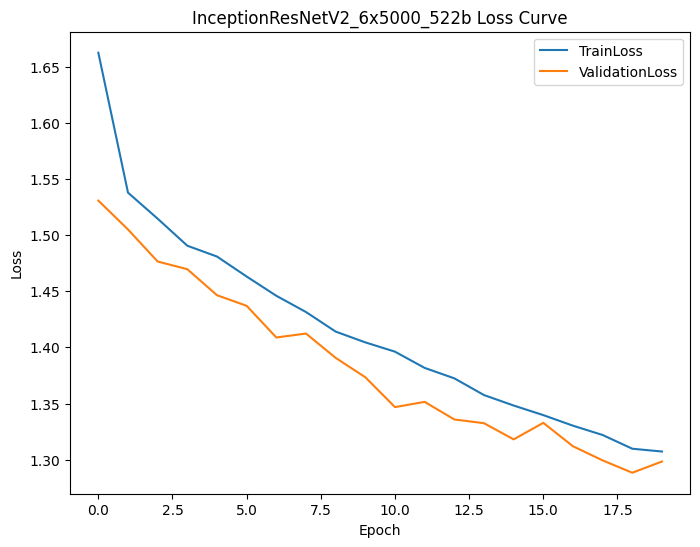

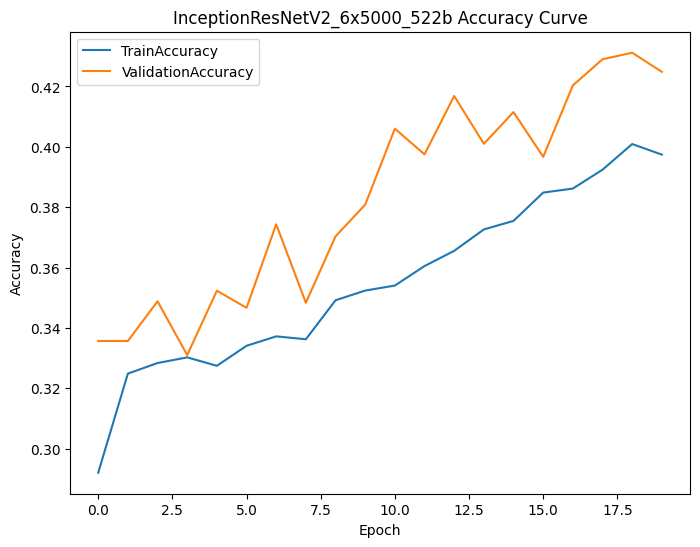

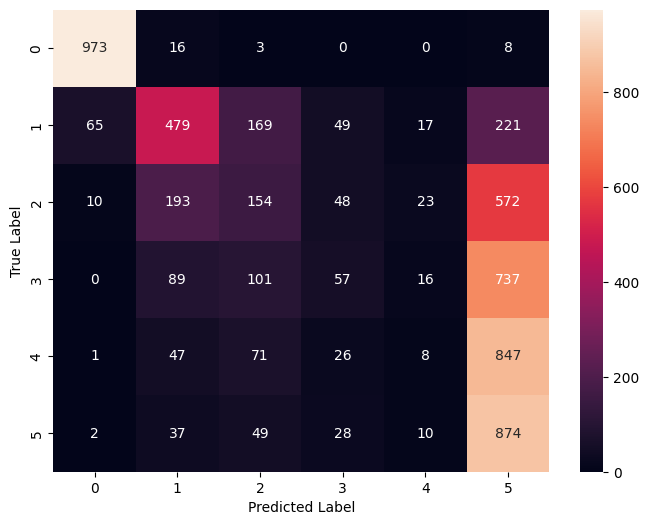

188/188 [==============================] - 8s 42ms/step - loss: 1.2984 - accuracy: 0.4242
Class=0|TP=973, FP=78, FN=27, TN=4922
Class=1|TP=479, FP=382, FN=521, TN=4618
Class=2|TP=154, FP=393, FN=846, TN=4607
Class=3|TP=57, FP=151, FN=943, TN=4849
Class=4|TP=8, FP=66, FN=992, TN=4934
Class=5|TP=874, FP=2385, FN=126, TN=2615
Metric evaluation for InceptionResNetV2_6x5000_522b>> 
{'InceptionResNetV2_6x5000_522b': {'loss': 1.2984, 'accuracy': 0.4242, '0_Precision': 0.9257849666983825, '0_Recall': 0.973, '0_F1_Score': 0.9488054607508533, '0_Specificity': 0.9844, '0_Accuracy': 0.9825, '1_Precision': 0.5563298490127758, '1_Recall': 0.479, '1_F1_Score': 0.5147770016120365, '1_Specificity': 0.9236, '1_Accuracy': 0.8495, '2_Precision': 0.28153564899451555, '2_Recall': 0.154, '2_F1_Score': 0.19909502262443438, '2_Specificity': 0.9214, '2_Accuracy': 0.7935, '3_Precision': 0.27403846153846156, '3_Recall': 0.057, '3_F1_Score': 0.09437086092715231, '3_Specificity': 0.9698, '3_Accuracy': 0.81766666666

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file InceptionResNetV2_6x5000_522b.h5


16293

In [38]:
model_inceptionresnet = create_InceptionResNet_Model()
inceptionresnet_train_history = train_model(model_inceptionresnet, f"InceptionResNetV2_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_inceptionresnet,  f"InceptionResNetV2_{test_remarks}", test_images, test_labels, test_labels_oh, inceptionresnet_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_inceptionresnet, f"InceptionResNetV2_{test_remarks}")
del model_inceptionresnet
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> InceptionResNet - overall accuracy 0.4242.  The curve line is not smooth, indicating a smaller learning rate may be required. Breaking down into classes, other than Qty 0, Qty 1 was having moderate recal at 0.479. However, the model seems unable to predict Qty 2, Qty 3 and Qty 4, as the recall for these Qty count were perform badly, with majority of the False Positive on predictive Qty 5! This signals the model overwhelmingly bias towards Qty 5 in the prediction. 


### 5.5 MobileNetV2

Epoch 1/20
188/188 [==============================] - 24s 98ms/step - loss: 1.6574 - accuracy: 0.3000 - val_loss: 1.5188 - val_accuracy: 0.3282
Epoch 2/20
188/188 [==============================] - 12s 61ms/step - loss: 1.5382 - accuracy: 0.3290 - val_loss: 1.4976 - val_accuracy: 0.3343
Epoch 3/20
188/188 [==============================] - 12s 61ms/step - loss: 1.5097 - accuracy: 0.3296 - val_loss: 1.4762 - val_accuracy: 0.3452
Epoch 4/20
188/188 [==============================] - 12s 61ms/step - loss: 1.4833 - accuracy: 0.3324 - val_loss: 1.4472 - val_accuracy: 0.3513
Epoch 5/20
188/188 [==============================] - 12s 62ms/step - loss: 1.4616 - accuracy: 0.3400 - val_loss: 1.4268 - val_accuracy: 0.3625
Epoch 6/20
188/188 [==============================] - 12s 61ms/step - loss: 1.4402 - accuracy: 0.3445 - val_loss: 1.4121 - val_accuracy: 0.3672
Epoch 7/20
188/188 [==============================] - 12s 62ms/step - loss: 1.4152 - accuracy: 0.3582 - val_loss: 1.3984 - val_accuracy:

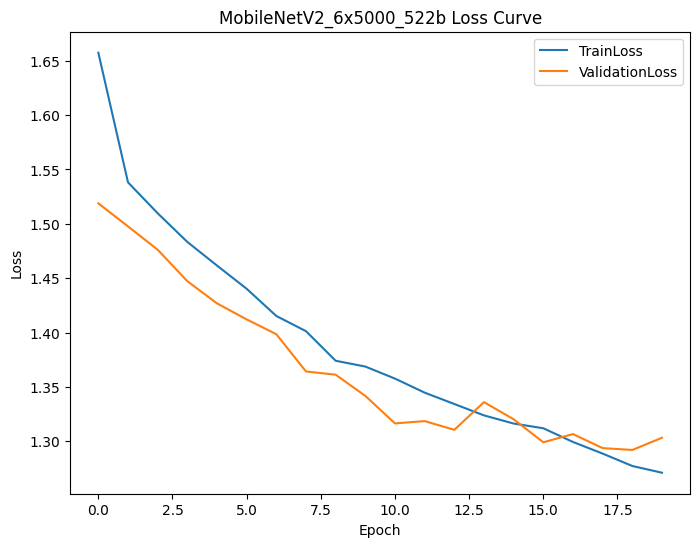

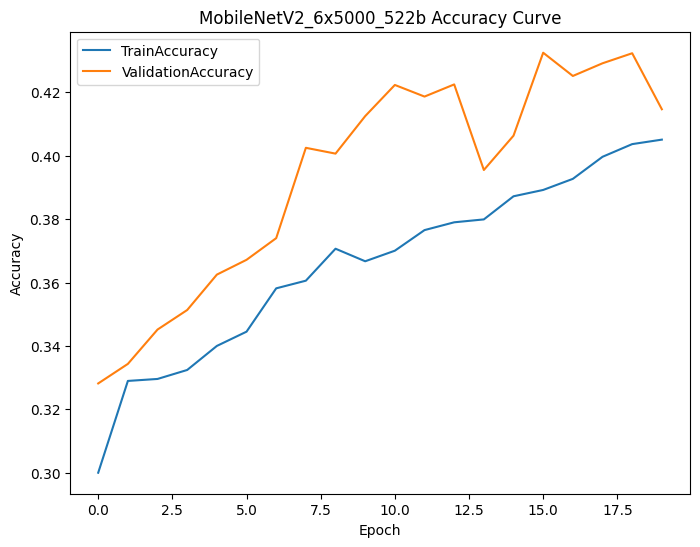

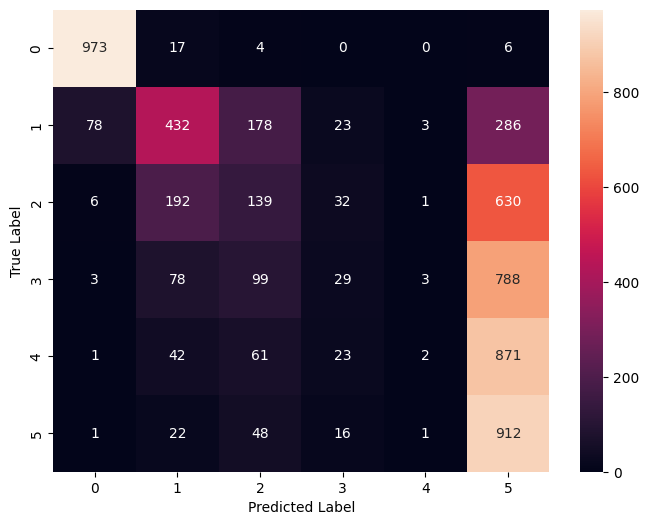

188/188 [==============================] - 3s 15ms/step - loss: 1.3031 - accuracy: 0.4145
Class=0|TP=973, FP=89, FN=27, TN=4911
Class=1|TP=432, FP=351, FN=568, TN=4649
Class=2|TP=139, FP=390, FN=861, TN=4610
Class=3|TP=29, FP=94, FN=971, TN=4906
Class=4|TP=2, FP=8, FN=998, TN=4992
Class=5|TP=912, FP=2581, FN=88, TN=2419
Metric evaluation for MobileNetV2_6x5000_522b>> 
{'MobileNetV2_6x5000_522b': {'loss': 1.3031, 'accuracy': 0.4145, '0_Precision': 0.916195856873823, '0_Recall': 0.973, '0_F1_Score': 0.9437439379243453, '0_Specificity': 0.9822, '0_Accuracy': 0.9806666666666667, '1_Precision': 0.5517241379310345, '1_Recall': 0.432, '1_F1_Score': 0.48457655636567587, '1_Specificity': 0.9298, '1_Accuracy': 0.8468333333333333, '2_Precision': 0.2627599243856333, '2_Recall': 0.139, '2_F1_Score': 0.18181818181818182, '2_Specificity': 0.922, '2_Accuracy': 0.7915, '3_Precision': 0.23577235772357724, '3_Recall': 0.029, '3_F1_Score': 0.051647373107747106, '3_Specificity': 0.9812, '3_Accuracy': 0.822

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file MobileNetV2_6x5000_522b.h5


18830

In [38]:
model_mobilenet = create_MobilenetV2_Model()
mobilenet_train_history = train_model(model_mobilenet, f"MobileNetV2_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_mobilenet,  f"MobileNetV2_{test_remarks}", test_images, test_labels, test_labels_oh, mobilenet_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_mobilenet, f"MobileNetV2_{test_remarks}")
del model_mobilenet
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> MobileNetV2 - overall accuracy 0.4145. The curve line is not smooth, indicating a smaller learning rate may be required. Breaking down into classes, other than Qty 0, Qty 1 was having moderate recal at 0.432. However, the model seems unable to predict Qty 2, Qty 3 and Qty 4, as the recall for these Qty count were perform badly, with majority of the False Positive on predictive Qty 5! This signals the model overwhelmingly bias towards Qty 5 in the prediction. 

### 5.6 VGG19

Epoch 1/20
188/188 [==============================] - 42s 180ms/step - loss: 1.6648 - accuracy: 0.2795 - val_loss: 1.4748 - val_accuracy: 0.3482
Epoch 2/20
188/188 [==============================] - 22s 118ms/step - loss: 1.5036 - accuracy: 0.3366 - val_loss: 1.3911 - val_accuracy: 0.4027
Epoch 3/20
188/188 [==============================] - 22s 118ms/step - loss: 1.4484 - accuracy: 0.3569 - val_loss: 1.3493 - val_accuracy: 0.4080
Epoch 4/20
188/188 [==============================] - 22s 118ms/step - loss: 1.4164 - accuracy: 0.3709 - val_loss: 1.3161 - val_accuracy: 0.4305
Epoch 5/20
188/188 [==============================] - 22s 118ms/step - loss: 1.3892 - accuracy: 0.3821 - val_loss: 1.3186 - val_accuracy: 0.4238
Epoch 6/20
188/188 [==============================] - 22s 118ms/step - loss: 1.3773 - accuracy: 0.3867 - val_loss: 1.2969 - val_accuracy: 0.4382
Epoch 7/20
188/188 [==============================] - 22s 118ms/step - loss: 1.3548 - accuracy: 0.3965 - val_loss: 1.2747 - val_ac

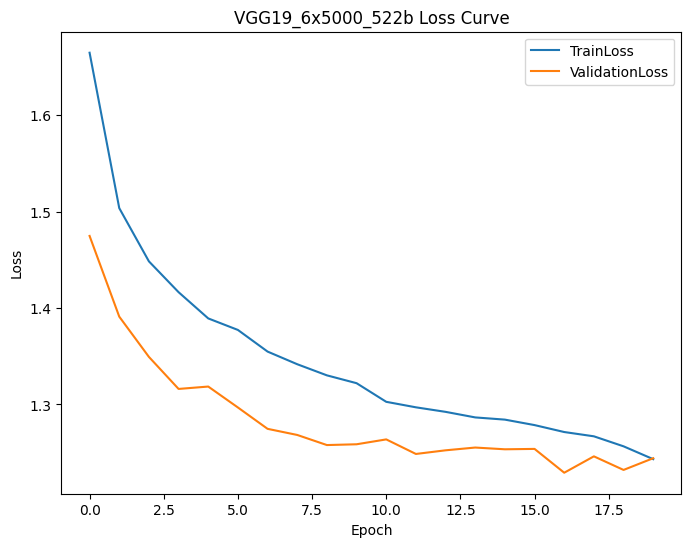

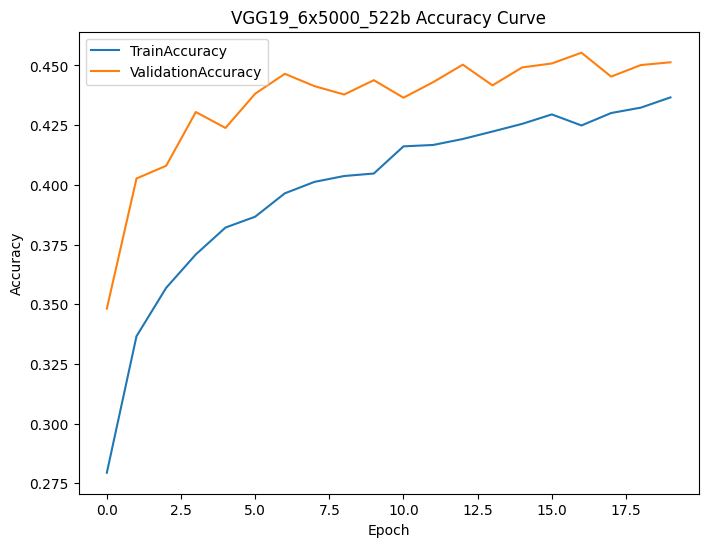

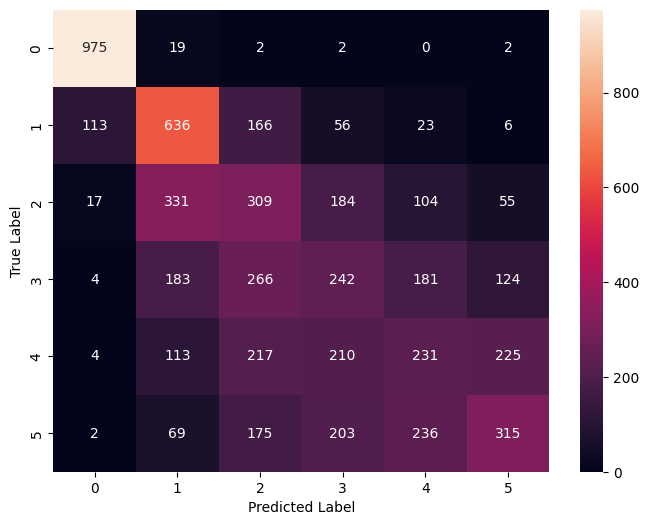

188/188 [==============================] - 5s 27ms/step - loss: 1.2442 - accuracy: 0.4513
Class=0|TP=975, FP=140, FN=25, TN=4860
Class=1|TP=636, FP=715, FN=364, TN=4285
Class=2|TP=309, FP=826, FN=691, TN=4174
Class=3|TP=242, FP=655, FN=758, TN=4345
Class=4|TP=231, FP=544, FN=769, TN=4456
Class=5|TP=315, FP=412, FN=685, TN=4588
Metric evaluation for VGG19_6x5000_522b>> 
{'VGG19_6x5000_522b': {'loss': 1.2442, 'accuracy': 0.4513, '0_Precision': 0.874439461883408, '0_Recall': 0.975, '0_F1_Score': 0.9219858156028369, '0_Specificity': 0.972, '0_Accuracy': 0.9725, '1_Precision': 0.4707623982235381, '1_Recall': 0.636, '1_F1_Score': 0.5410463632496809, '1_Specificity': 0.857, '1_Accuracy': 0.8201666666666667, '2_Precision': 0.27224669603524226, '2_Recall': 0.309, '2_F1_Score': 0.2894613583138173, '2_Specificity': 0.8348, '2_Accuracy': 0.7471666666666666, '3_Precision': 0.2697881828316611, '3_Recall': 0.242, '3_F1_Score': 0.25513969425408545, '3_Specificity': 0.869, '3_Accuracy': 0.7645, '4_Prec

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file VGG19_6x5000_522b.h5


17561

In [38]:
model_VGG = create_VGG_Model()
VGG_train_history = train_model(model_VGG, f"VGG19_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_VGG,  f"VGG19_{test_remarks}", test_images, test_labels, test_labels_oh, VGG_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_VGG, f"VGG19_{test_remarks}")
del model_VGG
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> VGG - overall accuracy 0.4513. The curve line is not smooth, indicating a smaller learning rate may be required. The accuracy and loss curve are not yet plateau after reaching epoch 20, highlighting the need for longer time to converge, but which also mean better performance can be expected as more training epoch continues. Breaking down into classes, small quantity 0 and 1 are having relatively high recall at 0.975 and 0.636. We see a drop in accuracy and recall due to the challenging object detection as the bin get more objects. In terms of the confusion matrix for VGG19, it shows higher concentration along the diagonal, indicating a balanced and higher level of true positive for each class.  

### 5.7 Customized CNN

Epoch 1/20
188/188 [==============================] - 76s 213ms/step - loss: 1.7294 - accuracy: 0.2210 - val_loss: 1.5573 - val_accuracy: 0.3447
Epoch 2/20
188/188 [==============================] - 19s 103ms/step - loss: 1.5072 - accuracy: 0.3346 - val_loss: 1.4859 - val_accuracy: 0.3582
Epoch 3/20
188/188 [==============================] - 19s 102ms/step - loss: 1.4503 - accuracy: 0.3574 - val_loss: 1.4889 - val_accuracy: 0.3463
Epoch 4/20
188/188 [==============================] - 19s 103ms/step - loss: 1.4183 - accuracy: 0.3722 - val_loss: 1.3706 - val_accuracy: 0.3997
Epoch 5/20
188/188 [==============================] - 19s 102ms/step - loss: 1.3931 - accuracy: 0.3815 - val_loss: 1.3852 - val_accuracy: 0.3813
Epoch 6/20
188/188 [==============================] - 19s 103ms/step - loss: 1.3761 - accuracy: 0.3905 - val_loss: 1.4119 - val_accuracy: 0.3665
Epoch 7/20
188/188 [==============================] - 19s 102ms/step - loss: 1.3657 - accuracy: 0.3967 - val_loss: 1.3153 - val_ac

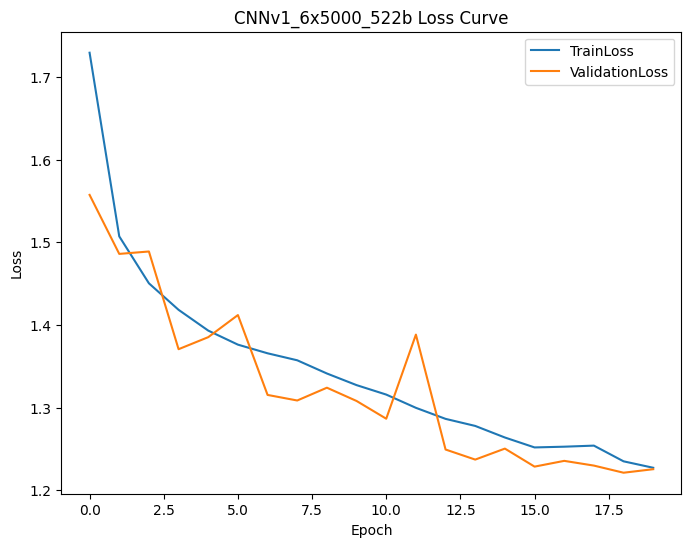

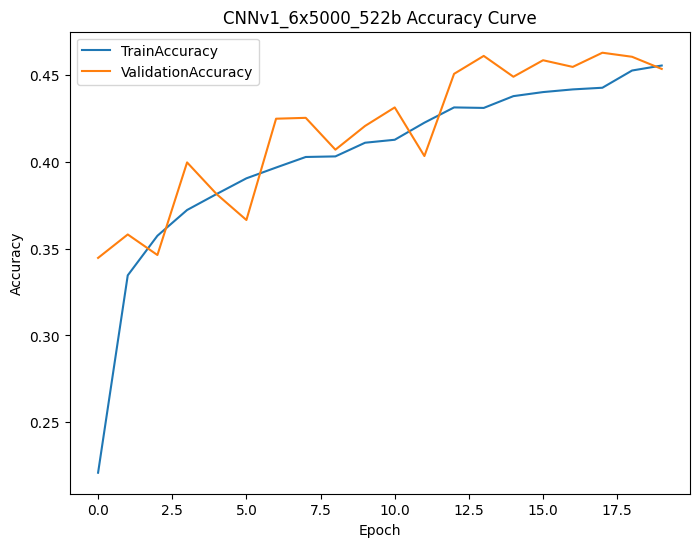

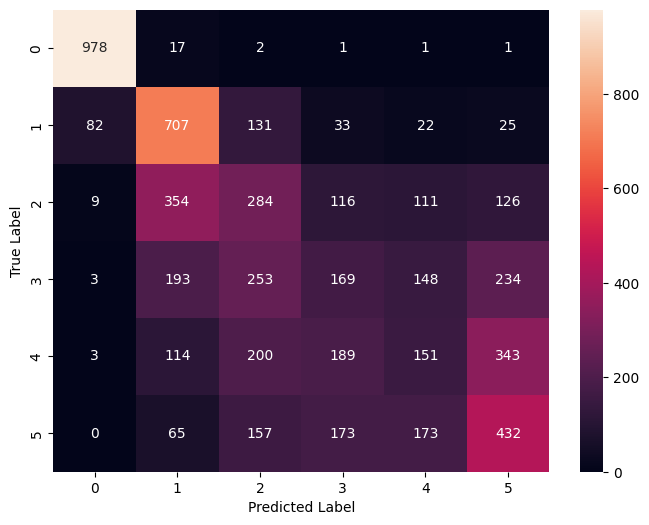

188/188 [==============================] - 2s 13ms/step - loss: 1.2254 - accuracy: 0.4535
Class=0|TP=978, FP=97, FN=22, TN=4903
Class=1|TP=707, FP=743, FN=293, TN=4257
Class=2|TP=284, FP=743, FN=716, TN=4257
Class=3|TP=169, FP=512, FN=831, TN=4488
Class=4|TP=151, FP=455, FN=849, TN=4545
Class=5|TP=432, FP=729, FN=568, TN=4271
Metric evaluation for CNNv1_6x5000_522b>> 
{'CNNv1_6x5000_522b': {'loss': 1.2254, 'accuracy': 0.4535, '0_Precision': 0.9097674418604651, '0_Recall': 0.978, '0_F1_Score': 0.9426506024096385, '0_Specificity': 0.9806, '0_Accuracy': 0.9801666666666666, '1_Precision': 0.48758620689655174, '1_Recall': 0.707, '1_F1_Score': 0.5771428571428572, '1_Specificity': 0.8514, '1_Accuracy': 0.8273333333333334, '2_Precision': 0.2765335929892892, '2_Recall': 0.284, '2_F1_Score': 0.2802170695609275, '2_Specificity': 0.8514, '2_Accuracy': 0.7568333333333334, '3_Precision': 0.24816446402349487, '3_Recall': 0.169, '3_F1_Score': 0.20107079119571686, '3_Specificity': 0.8976, '3_Accuracy':

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Exported trained model to file CNNv1_6x5000_522b.h5


17348

In [38]:
model_cnn = create_CNN_Model()
cnn_train_history = train_model(model_cnn, f"CNNv1_{test_remarks}", train_images, train_labels_oh, test_images, test_labels_oh, image_augment)
eval_model(model_cnn,  f"CNNv1_{test_remarks}", test_images, test_labels, test_labels_oh, cnn_train_history, evaluate_result, nClasses)
save_eval_result(evaluate_result,test_remarks)
export_trained_model(model_cnn, f"CNNv1_{test_remarks}")
del model_cnn
gc.collect() #force garbage collection to clear up unused memory, for subsequent run

> customized CNN - overall accuracy 0.4535. The curve line is not smooth, indicating a smaller learning rate may be required. From the confusion matrix, the customized CNN seems to perform similar to VGG19, where higher concentration along the diagonal. However, per-class recall for customized CNN did not perform better than VGG19, which bias in predicting Qty 5 is observed. 

Load the `eval_result` into pandas dataframe in order to get a tabular view, and the dataframe is exported to CSV for future reference

In [43]:
eval_result_df = pd.DataFrame(evaluate_result).T
eval_result_df.reset_index(inplace=True)
eval_result_df.rename(columns={'index':'Model_Eval'}, inplace=True)
eval_result_df.to_csv(f'{drive_path}/02_ModelEval_EvalResult_{test_remarks}.csv', mode = 'a', index=False, header=True)

eval_result_df

,Model_Eval,0_Accuracy,0_F1_Score,0_Precision,0_Recall,0_Specificity,1_Accuracy,1_F1_Score,1_Precision,1_Recall,...,4_Precision,4_Recall,4_Specificity,5_Accuracy,5_F1_Score,5_Precision,5_Recall,5_Specificity,accuracy,loss
0,CNNv1_6x5360_521a,0.965556,0.902973,0.851032,0.961667,0.966333,0.773333,0.470817,0.38535,0.605,...,0.231884,0.346667,0.770333,0.757222,0.334855,0.308123,0.366667,0.835333,0.4061,1.3448


> Summary: VGG19 is the better performer in this model evaluation, with initial accuracy score at 0.4513. VGG shows promising result, where the accuracy has not reach plateau the time the epoch run was over, while the confusion matrix shows the balanced prediction across the different classes. EfficientNet was totally not able to generalize any of the features, resulting in horizontal loss curve from the onset of the epoch, and training was early stopped by regularization on the 5th epoch. Other than VGG and EfficientNet, all models experienced overfitting, as well as overwhelming bias prediction towards a particular class. To the surprise was the CNN model where it scored the second best at 0.4535, with a relatively balanced prediction to each class, with slight bias towards Qty 5. However, given that it takes more resources to hypertune a customized CNN model, therefore VGG pretrained model will be used in the final hyperparameter tuning. 